## Курсовой проект по курсу "Python для Data Science"

#### Задание:

#### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
# Библиотека построения графиков
import matplotlib
# Модуль для работы с изображениями
import matplotlib.image as img
# Модуль для работы с графиками
import matplotlib.pyplot as plt
# Альтернативный модуль pyplot'у для работы с графиками 
import seaborn as sns

import random

# Команда для построение графиков в ноутбуке
%matplotlib inline
# Никогда не печатать предупреждения
import warnings
warnings.filterwarnings('ignore')
# работа с датой
from datetime import datetime
# разбиение, поиск по сетки, фолды
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# Градиентный бустинг
from sklearn.ensemble import GradientBoostingRegressor
# Метрика r2_score
from sklearn.metrics import r2_score

In [2]:
# Для просмотра всех столбцов DataFrame при выводе
pd.options.display.max_columns = 40

# Установим размер шрифта на всех графиках
matplotlib.rcParams.update({'font.size': 14})

## Real Estate Price Prediction

### 1. Загрузка данных

In [3]:
DATASET_PATH = 'data/train.csv'
PREPARED_DATASET_PATH = 'data/prepared_train'
TEST_DATASET_PATH = 'data/test.csv'

In [4]:
train_df = pd.read_csv(DATASET_PATH, sep=',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### 2. EDA

#### Распределение цлевой переменной

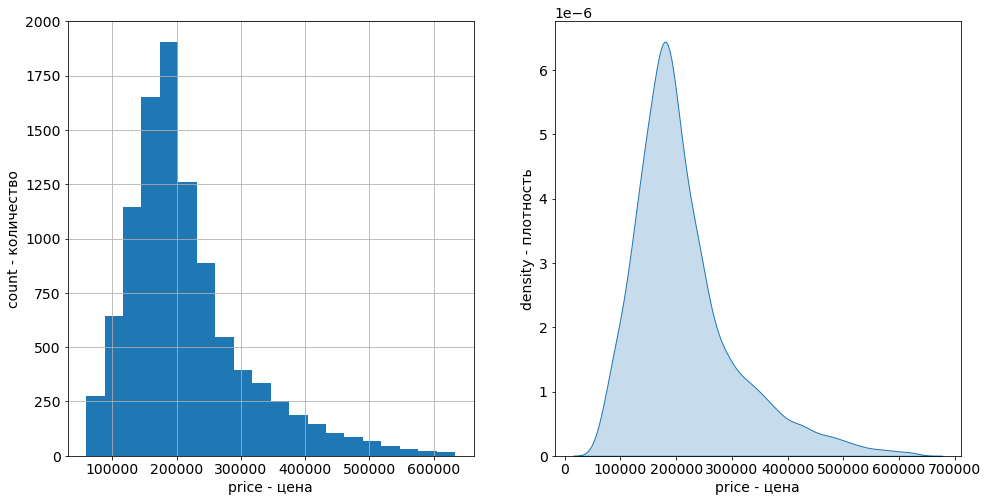

In [6]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=20)
plt.xlabel('price - цена')
plt.ylabel('count - количество')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price - цена')
plt.ylabel('density - плотность')

plt.show()

In [7]:
# Меры центральной тенденции
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

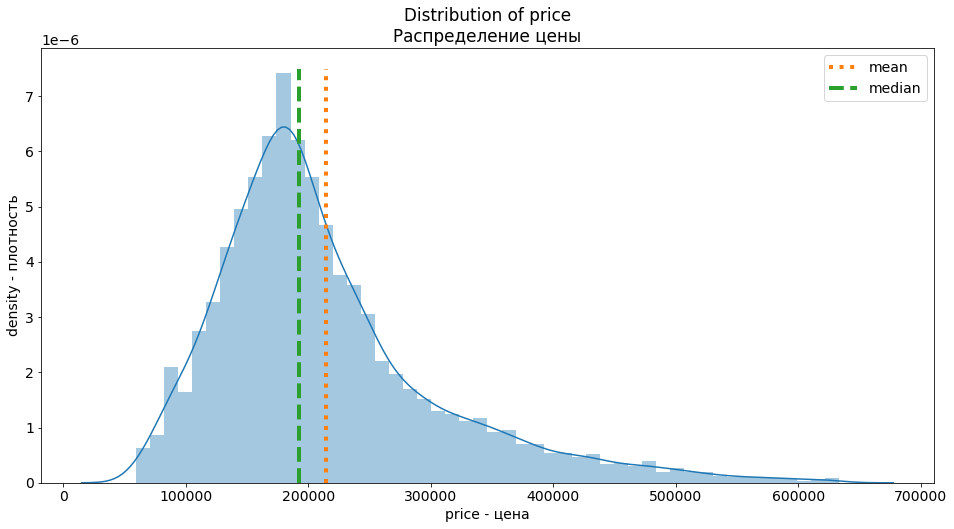

In [8]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)
plt.xlabel('price - цена')
plt.ylabel('density - плотность')

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.legend()
plt.title('Distribution of price\nРаспределение цены')


plt.show()

#### Анализ признаков

In [9]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [10]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [11]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [12]:
train_df['Social_2'].value_counts().sort_index()

168      190
186       11
264      587
290       11
388       56
        ... 
11395     95
12238     79
13670    204
14892    151
19083    176
Name: Social_2, Length: 142, dtype: int64

In [13]:
train_df['Social_3'].value_counts().sort_index().head()

0    2997
1    1861
2     635
3    1136
4     835
Name: Social_3, dtype: int64

In [14]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [15]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [17]:
train_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_num_features.drop(['Id', 'DistrictId', 'Price'], axis=1, inplace=True)
train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


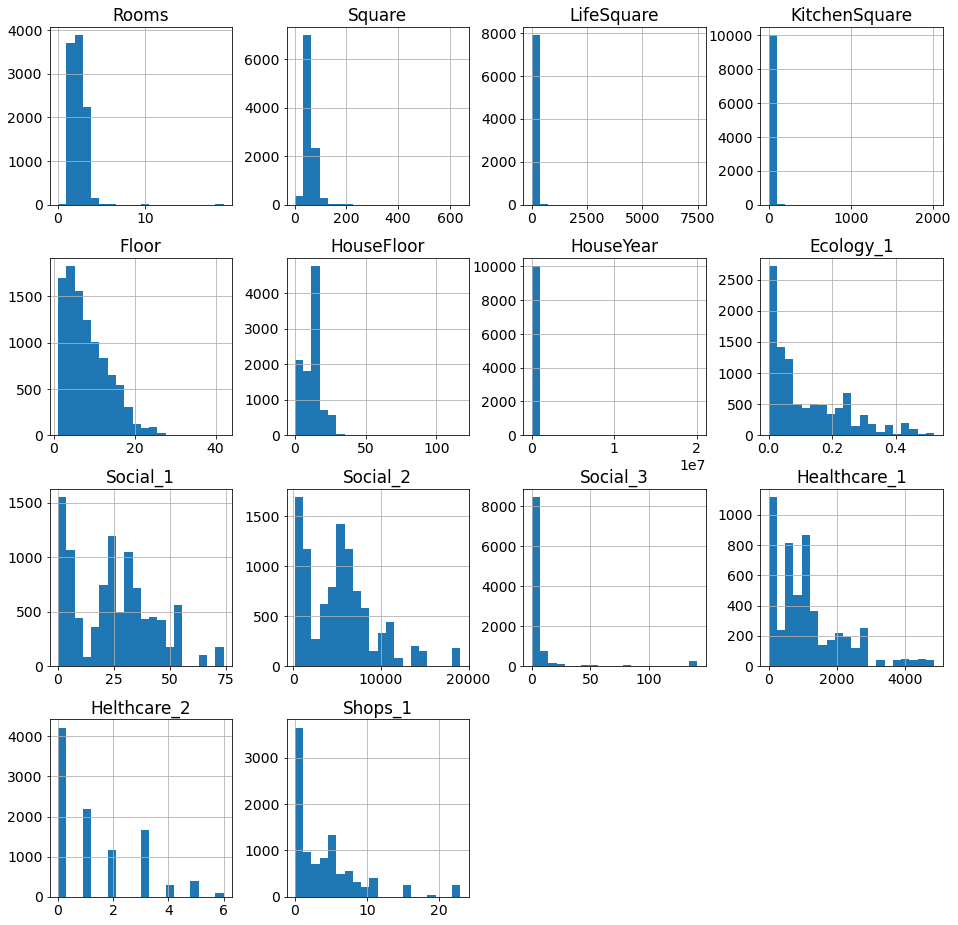

In [18]:
train_num_features.hist(figsize=(16, 16), bins=20)

plt.show() 

#### Взаимное распределение между признаками

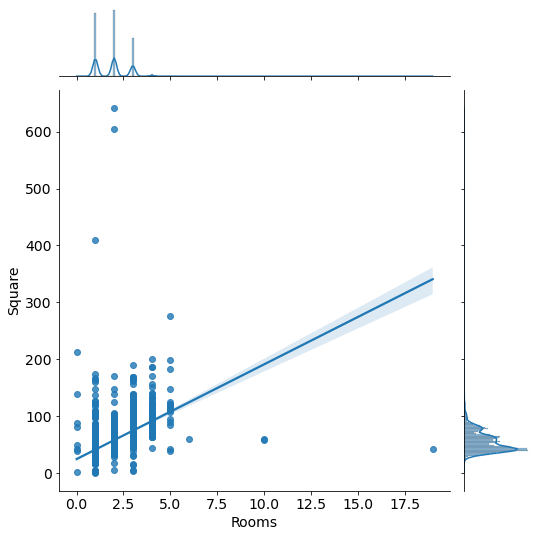

In [19]:
grid = sns.jointplot(train_df['Rooms'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

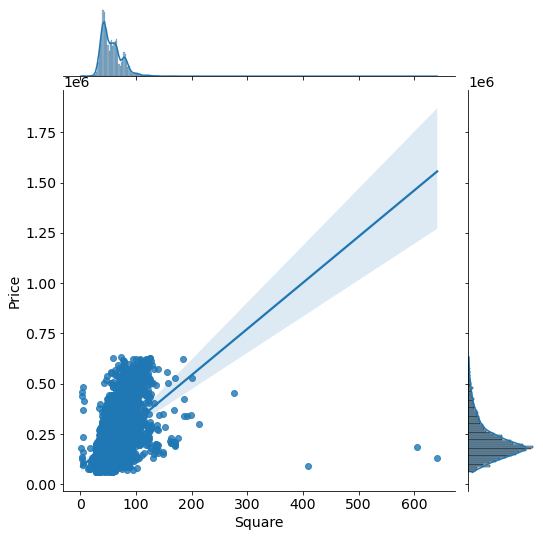

In [20]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

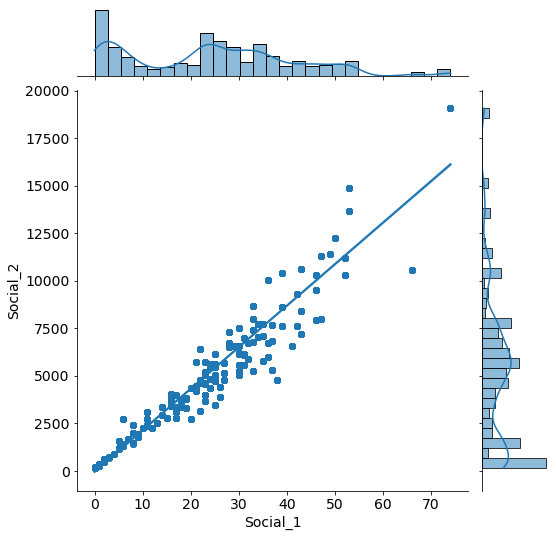

In [21]:
grid = sns.jointplot(train_df['Social_1'], train_df['Social_2'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

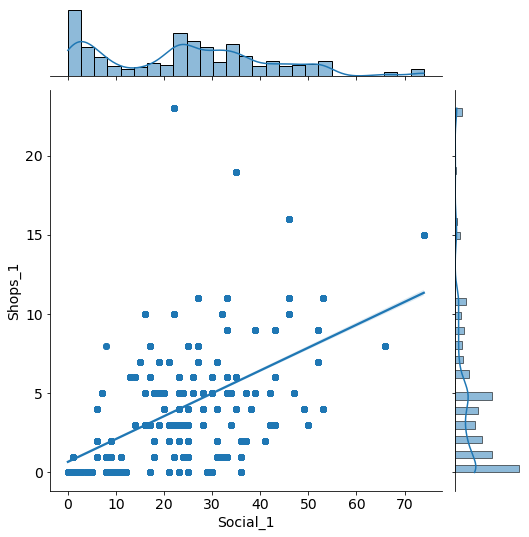

In [22]:
grid = sns.jointplot(train_df['Social_1'], train_df['Shops_1'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### Матрица кориляций

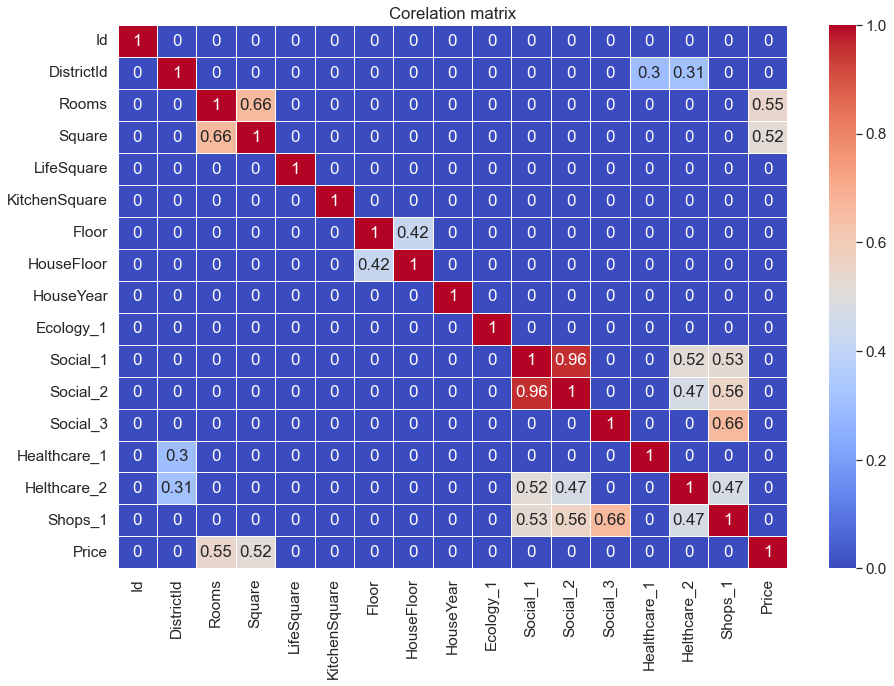

In [23]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Corelation matrix')
plt.show()

### 3. Очистка данных и feature engineering

In [24]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Rooms

In [25]:
# Посмотри по количеству комнат
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [26]:
# Найдём квартиры, в которых площадь в зависимости от количество комнат меньше 85
# так например 5, 10, 19-комнатные квартиры не могут иметь площадь меньше 85 м2
train_df.loc[(train_df['Rooms'].between(5, 19)) & (train_df['Square'] < 85),\
             ['Rooms', 'Square', 'Price']].sort_values(by='Rooms')

,Rooms,Square,Price
2799,5.0,42.003293,112693.641769
7975,5.0,39.906082,206148.845716
8794,6.0,59.414334,229661.964416
2004,10.0,59.056975,317265.323792
2728,10.0,60.871266,172329.270863
6088,19.0,42.006046,78364.616704


In [27]:
# Также имеются записи, где 0 комнат посмотрим поближе площадь и стоимость
train_df.loc[train_df['Rooms'] == 0, ['Rooms', 'Square', 'Price']]

,Rooms,Square,Price
2194,0.0,38.697117,158998.110646
3780,0.0,41.790881,98129.976788
5894,0.0,49.483501,217009.338463
6401,0.0,87.762616,219281.918007
7644,0.0,212.932361,302211.260887
7929,0.0,81.491446,212864.799112
9767,0.0,138.427694,268394.744389
9869,0.0,2.377248,126596.941798


In [28]:
# Посмотрим площадь квартир по медиане, так как медиана меньше реагирует на выбросы
train_df.groupby(by='Rooms', as_index=False).agg({'Square':'median'})

,Rooms,Square
0,0.0,65.487474
1,1.0,40.406590
2,2.0,55.841812
3,3.0,77.413643
4,4.0,98.668054
5,5.0,116.084861
6,6.0,59.414334
7,10.0,59.964120
8,19.0,42.006046


In [29]:
# Напишем функцию для обработки выбросов rooms в зависимости от square
def rooms_sqaure(rooms_outlier):
    """Функция приведения rooms в зависимости от square"""
    for idx in rooms_outlier.index:
        square = rooms_outlier.loc[idx, 'Square']
        if  0 < square <= 45:
            rooms_outlier.loc[idx, 'Rooms'] = 1
            # Если площадь меньше 11 м2
            if square < 20:
                rooms_outlier.loc[idx, 'Square'] = 15
        elif 45 < square <= 60:
            rooms_outlier.loc[idx, 'Rooms'] = 2
        elif 60 < square <= 80:
            rooms_outlier.loc[idx, 'Rooms'] = 3
        elif 80 < square <= 100:
            rooms_outlier.loc[idx, 'Rooms'] = 4
        elif 100 < square <= 140:
            rooms_outlier.loc[idx, 'Rooms'] = 5
        else:
            rooms_outlier.loc[idx, 'Rooms'] = 6
    return rooms_outlier

In [30]:
rooms_outlier = train_df.loc[(train_df['Rooms'].between(5, 19)) & 
                             (train_df['Square'] < 85), ['Rooms', 'Square']]
rooms_outlier = rooms_sqaure(rooms_outlier)
rooms_outlier

,Rooms,Square
2004,2.0,59.056975
2728,3.0,60.871266
2799,1.0,42.003293
6088,1.0,42.006046
7975,1.0,39.906082
8794,2.0,59.414334


In [31]:
# Изменим количество комнат
train_df.loc[(train_df['Rooms'].between(5, 19)) & (train_df['Square'] < 85), 'Rooms'] = rooms_outlier['Rooms']

In [32]:
# Так же обработаем и 0 комнаты
rooms_outlier = train_df.loc[train_df['Rooms'] == 0, ['Rooms', 'Square']]
rooms_outlier = rooms_sqaure(rooms_outlier)

In [33]:
train_df.loc[train_df['Rooms'] == 0, ['Rooms', 'Square']] = rooms_outlier[['Rooms', 'Square']]

In [34]:
train_df['Rooms'].value_counts()

2.0    3883
1.0    3711
3.0    2236
4.0     152
5.0      17
6.0       1
Name: Rooms, dtype: int64

#### Square

In [35]:
train_df['Square'].describe()

count    10000.000000
mean        56.317037
std         21.055876
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [36]:
# Так же имеются выбросы min = 1.13 и max = 641
train_df.loc[(train_df['Square'] > 185) | (train_df['Square'] < 11)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
2790,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083


In [37]:
train_df['Square'].quantile(.998)

163.28738148712702

In [38]:
train_df['Square'].quantile(.0012)

14.998541837714704

In [39]:
# Создадим бинарный признак для Square
train_df['Square_outlier'] = 0

In [40]:
# где имеются выбросы заполним 1
train_df.loc[train_df['Square'] < 11, 'Square_outlier'] = 1
train_df.loc[train_df['Square'] > 185, 'Square_outlier'] = 1

In [41]:
# Заполним выбросы, которые меньше 11 м2 квантилями
train_df.loc[train_df['Square'] < 11, 'Square'] = train_df['Square'].quantile(.0012)

In [42]:
# Заполним выбросы, которые больше 213 м2 квантилями
train_df.loc[train_df['Square'] > 185, 'Square'] = train_df['Square'].quantile(.998)

In [43]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,8383.40770,50.400800,1.888400,56.181970,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210
std,4859.01902,43.587592,0.812411,18.981977,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578
min,0.00000,0.000000,1.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000
max,16798.00000,209.000000,6.000000,183.382273,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000


In [44]:
# Еще раз посмотрим площади и количество комнат
train_df.loc[train_df['Square_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier
161,6782,45,1.0,14.998542,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,1
328,4504,27,3.0,14.998542,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,1
726,28,9,2.0,163.287381,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,1
1401,9487,5,1.0,14.998542,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,1
1606,3718,56,3.0,163.287381,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979,1
1776,16568,27,4.0,163.287381,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,1
1906,5548,86,5.0,163.287381,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,1
2790,15947,129,4.0,163.287381,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253,1
4496,15744,34,1.0,14.998542,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,1
4800,7657,38,1.0,14.998542,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,1


In [45]:
# Видно, что имеются площади, которые не соответствуют по количеству комнат

In [46]:
# Исправим эти выбросы функйцией rooms_square
rooms_outlier = train_df.loc[train_df['Square_outlier'] == 1, ['Rooms', 'Square']]
rooms_outlier = rooms_sqaure(rooms_outlier)

In [47]:
train_df.loc[train_df['Square_outlier'] == 1, ['Rooms', 'Square']] = rooms_outlier[['Rooms', 'Square']]

In [48]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,8383.40770,50.400800,1.890300,56.181972,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210
std,4859.01902,43.587592,0.819593,18.981973,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578
min,0.00000,0.000000,1.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000
max,16798.00000,209.000000,6.000000,183.382273,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000


#### KitchenSquare

In [49]:
train_df.groupby(by='Rooms', as_index=False).agg({'KitchenSquare': 'median'})

,Rooms,KitchenSquare
0,1.0,6.0
1,2.0,6.0
2,3.0,7.0
3,4.0,8.0
4,5.0,9.0
5,6.0,14.5


In [50]:
# Посмотрим на KitchenSqaure
train_df.loc[train_df['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945,0
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,10268,27,1.0,36.112393,1.855415,1.0,9,16.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,94881.691800,0
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0
9990,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.221700,0
9991,11173,6,2.0,62.648779,NaN,0.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872,0


In [51]:
# Много записей имеют несоответствие, так например в 3, 2 или 1-комнатной квартире площадь кухни
# составляет 1 или 2 м2, что врядли

In [52]:
# Создадим признак, в котором пометим имеющиеся выбросы
train_df['Kitchen_outlier'] = 0
train_df.loc[train_df['KitchenSquare'] < 3, 'Kitchen_outlier'] = 1

In [53]:
# Посчитаем какие квартиры имеют выбросы по площади KitchenSquare
train_df.loc[train_df['Kitchen_outlier'] == 1, ['Rooms', 'KitchenSquare']].value_counts('Rooms')

Rooms
1.0    1343
2.0    1212
3.0     579
4.0      22
5.0       3
6.0       2
dtype: int64

In [54]:
# Напишем функцию для обработки выбросов KitchenSquare от Rooms
def rooms_kitchen_square(kitchen_outlier):
    """Функция приведения KitchenSquare от Rooms"""
    for idx in kitchen_outlier.index:
        rooms = kitchen_outlier.loc[idx, 'Rooms']
        if rooms == 1:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 3
        elif rooms == 2:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 6
        elif rooms == 3:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 8
        elif rooms == 4:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 10
        elif rooms == 5:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 12
        else:
            kitchen_outlier.loc[idx, 'KitchenSquare'] = 25
    return kitchen_outlier

In [55]:
kitchen_outlier = train_df.loc[train_df['Kitchen_outlier'] == 1, ['Rooms', 'KitchenSquare']]
kitchen_outlier = rooms_kitchen_square(kitchen_outlier)

In [56]:
kitchen_outlier.value_counts()

Rooms  KitchenSquare
1.0    3.0              1343
2.0    6.0              1212
3.0    8.0               579
4.0    10.0               22
5.0    12.0                3
6.0    25.0                2
dtype: int64

In [57]:
# Заменим данные по площади кухни
train_df.loc[train_df['Kitchen_outlier'] == 1, ['Rooms', 'KitchenSquare']] =\
             kitchen_outlier[['Rooms', 'KitchenSquare']]

In [58]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,37.199645,7.650400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.316100
std,4859.01902,43.587592,0.819593,18.981973,86.241209,28.389589,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.464976
min,0.00000,0.000000,1.000000,13.784865,0.370619,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,5.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,7.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000
max,16798.00000,209.000000,6.000000,183.382273,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000


In [59]:
# Посмотрим на KitchenSqaure > 33 м2
train_df.loc[train_df['KitchenSquare'] > 33, ['Rooms', 'Square', 'KitchenSquare']]

,Rooms,Square,KitchenSquare
286,3.0,123.430072,123.0
456,1.0,46.013187,43.0
682,2.0,64.859242,62.0
755,1.0,35.813564,35.0
1614,3.0,138.980817,43.0
1728,3.0,79.722243,72.0
2108,1.0,43.292516,40.0
2325,2.0,139.070296,42.0
2454,3.0,97.490674,96.0
2702,1.0,48.128114,48.0


In [60]:
# Пометим выбросы
train_df.loc[train_df['KitchenSquare'] > 33, 'Kitchen_outlier'] = 1

In [61]:
# Обработаем данные
kitchen_outlier = train_df.loc[(train_df['Kitchen_outlier'] == 1) & (train_df['KitchenSquare'] > 33),\
                              ['Rooms', 'Square', 'KitchenSquare']]
kitchen_outlier = rooms_kitchen_square(kitchen_outlier)

In [62]:
# Заменим данные по площади кухни
train_df.loc[(train_df['Kitchen_outlier'] == 1) & (train_df['KitchenSquare'] > 33), 'KitchenSquare']\
              = kitchen_outlier['KitchenSquare']

In [63]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,37.199645,7.080400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.319400
std,4859.01902,43.587592,0.819593,18.981973,86.241209,2.740344,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.466267
min,0.00000,0.000000,1.000000,13.784865,0.370619,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,5.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,7.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000
max,16798.00000,209.000000,6.000000,183.382273,7480.592129,32.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000


#### LifeSquare

In [64]:
# Посмотрим на пропуски в признаке LifeSquare
train_df.loc[train_df['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1
18,4581,1,1.0,47.582480,NaN,3.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0,1
20,8768,63,1.0,50.974891,NaN,3.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,0,1
24,4717,27,1.0,44.203947,NaN,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1
9978,4851,1,1.0,39.314342,NaN,3.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0,1
9981,6753,62,2.0,73.092686,NaN,6.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,0,1
9983,647,1,2.0,63.324025,NaN,6.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1


In [65]:
# Создадим признак, в котором пометим имеющиеся пропуски
train_df['LifeSquare_nan'] = 0

In [66]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [67]:
train_df.loc[train_df['LifeSquare_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,1
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,1
18,4581,1,1.0,47.582480,NaN,3.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0,1,1
20,8768,63,1.0,50.974891,NaN,3.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,0,1,1
24,4717,27,1.0,44.203947,NaN,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1,1
9978,4851,1,1.0,39.314342,NaN,3.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0,1,1
9981,6753,62,2.0,73.092686,NaN,6.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,0,1,1
9983,647,1,2.0,63.324025,NaN,6.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1,1


In [68]:
# Заполним пропуски (4 м2 на коридоры)
condition = train_df['LifeSquare_nan'] == 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - \
            train_df.loc[condition, 'KitchenSquare'] - 4

In [69]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,40.046532,7.080400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.319400,0.211300
std,4859.01902,43.587592,0.819593,18.981973,77.241579,2.740344,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.466267,0.408251
min,0.00000,0.000000,1.000000,13.784865,0.370619,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.131851,5.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,35.119672,7.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,48.069469,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000,0.000000
max,16798.00000,209.000000,6.000000,183.382273,7480.592129,32.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000,1.000000


In [70]:
# Посмотрим на выбросы в признаке LifeSquare

In [71]:
# Вариант, когда LifeSquare > Square
train_df.loc[train_df['LifeSquare'] > train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan
33,847,74,2.0,73.314975,74.131261,6.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,1,0
64,3992,1,3.0,87.200625,87.730225,8.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669,0,1,0
77,11771,45,1.0,38.467276,39.624493,3.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,1,0
100,13343,74,2.0,79.937665,82.931595,6.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168,0,1,0
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,0
9979,2201,6,1.0,40.043234,41.984322,3.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,1,0
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0


In [72]:
# Создадим признак, в котором пометим имеющиеся выбросы
train_df['LifeSquare_outlier'] = 0

In [73]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare_outlier'] = 1

In [74]:
train_df.loc[train_df['LifeSquare_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
33,847,74,2.0,73.314975,74.131261,6.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,1,0,1
64,3992,1,3.0,87.200625,87.730225,8.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669,0,1,0,1
77,11771,45,1.0,38.467276,39.624493,3.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,1,0,1
100,13343,74,2.0,79.937665,82.931595,6.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168,0,1,0,1
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,1
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,0,1
9979,2201,6,1.0,40.043234,41.984322,3.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,1,0,1
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0,1


In [75]:
condition = train_df['LifeSquare_outlier'] == 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] -\
             train_df.loc[condition, 'KitchenSquare'] - 4

In [76]:
train_df.loc[train_df['LifeSquare_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
33,847,74,2.0,73.314975,63.314975,6.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,1,0,1
64,3992,1,3.0,87.200625,75.200625,8.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669,0,1,0,1
77,11771,45,1.0,38.467276,31.467276,3.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,1,0,1
100,13343,74,2.0,79.937665,69.937665,6.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168,0,1,0,1
111,13875,20,1.0,28.438794,18.438794,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,84.056784,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,1
9962,14175,14,1.0,42.029175,28.029175,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,0,1
9979,2201,6,1.0,40.043234,33.043234,3.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,1,0,1
9987,11665,1,2.0,62.690057,48.690057,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0,1


In [77]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,38.565598,7.080400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.319400,0.211300,0.047800
std,4859.01902,43.587592,0.819593,18.981973,18.191145,2.740344,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.466267,0.408251,0.213353
min,0.00000,0.000000,1.000000,13.784865,0.370619,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,24.888795,5.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,34.697451,7.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,47.681530,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000,0.000000,0.000000
max,16798.00000,209.000000,6.000000,183.382273,161.504222,32.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000,1.000000,1.000000


In [78]:
# Вариант, когда LifeSquare < KitchenSquare
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
26,8553,88,3.0,83.262530,4.769174,8.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020,0,1,0,0
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174741.998061,0,0,0,0
227,3746,62,1.0,46.722042,1.944446,3.0,11,12.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.121715,0,1,0,0
258,4280,34,2.0,61.334968,4.091945,6.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972,0,1,0,0
270,8997,74,1.0,43.227719,1.726270,3.0,9,17.0,2016,0.075779,B,B,6,1437,3,NaN,0,2,B,154565.271940,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,15127,150,1.0,17.046188,5.046188,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,NaN,1,9,B,74222.110465,0,0,0,1
9746,7857,27,2.0,43.956044,10.523868,19.0,15,17.0,2006,0.075424,B,B,11,3097,0,NaN,0,0,B,143688.076514,0,0,0,0
9869,3224,27,1.0,15.000000,0.873147,3.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,0,1,0,0
9938,2913,34,4.0,94.888593,2.637095,10.0,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.506507,0,1,0,0


In [79]:
# Наблюдаем 161 запись

In [80]:
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare'], 'LifeSquare_outlier'] = 1

In [81]:
condition = train_df['LifeSquare_outlier'] == 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] -\
             train_df.loc[condition, 'KitchenSquare'] - 4

In [82]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,39.341343,7.080400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.319400,0.211300,0.063600
std,4859.01902,43.587592,0.819593,18.981973,17.862952,2.740344,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.466267,0.408251,0.244051
min,0.00000,0.000000,1.000000,13.784865,2.784865,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,26.060344,5.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,35.112726,7.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,48.120836,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000,0.000000,0.000000
max,16798.00000,209.000000,6.000000,183.382273,161.504222,32.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000,1.000000,1.000000


#### Floor, HouseFloor

In [83]:
# Посмотрим на выбросы по HouseFloor
train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566,0,0,0,0
19,367,45,1.0,42.367289,40.012529,3.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777,0,1,0,0
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494,0,0,0,0
24,4717,27,1.0,44.203947,37.203947,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,1,0
25,4521,6,2.0,65.409965,55.409965,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,84.056784,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,1
9968,9920,1,3.0,86.487550,74.487550,8.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528,0,1,1,0
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713,0,0,0,0
9975,4944,6,2.0,52.573133,42.573133,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1,1,0


In [84]:
# Создадим признак, в котором пометим имеющиеся выбросы
train_df['HouseFloor_outlier'] = 0

In [85]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [86]:
train_df.loc[train_df['HouseFloor_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566,0,0,0,0,1
19,367,45,1.0,42.367289,40.012529,3.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777,0,1,0,0,1
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494,0,0,0,0,1
24,4717,27,1.0,44.203947,37.203947,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,1,0,1
25,4521,6,2.0,65.409965,55.409965,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,84.056784,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,1,1
9968,9920,1,3.0,86.487550,74.487550,8.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528,0,1,1,0,1
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713,0,0,0,0,1
9975,4944,6,2.0,52.573133,42.573133,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1,1,0,1


In [87]:
train_df.loc[train_df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier
24,4717,27,1.0,44.203947,37.203947,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,1,0,1
152,12947,53,2.0,56.023342,46.023342,6.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832,0,1,1,0,1
159,13146,74,1.0,46.449711,39.449711,3.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148,0,1,1,0,1
186,12174,62,1.0,44.954880,37.954880,3.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722,0,1,1,0,1
229,15661,45,3.0,81.094922,69.094922,8.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,35.936724,3.0,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139,0,1,1,0,1
9931,15686,1,1.0,47.402412,40.402412,3.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224,0,1,1,0,1
9940,4711,6,1.0,41.224118,34.224118,3.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104,0,1,1,0,1
9950,5383,48,3.0,98.994909,86.994909,8.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446,0,1,1,0,1


In [88]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

In [89]:
train_df.loc[train_df['HouseFloor_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566,0,0,0,0,1
19,367,45,1.0,42.367289,40.012529,3.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777,0,1,0,0,1
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494,0,0,0,0,1
24,4717,27,1.0,44.203947,37.203947,3.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,1,0,1
25,4521,6,2.0,65.409965,55.409965,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,84.056784,8.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,1,1
9968,9920,1,3.0,86.487550,74.487550,8.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528,0,1,1,0,1
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713,0,0,0,0,1
9975,4944,6,2.0,52.573133,42.573133,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1,1,0,1


In [90]:
# Заполним нулевую этажность мединой
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [91]:
floor_outlier = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

In [92]:
train_df.loc[floor_outlier, 'Floor'] = train_df.loc[floor_outlier, 'HouseFloor'].\
                                       apply(lambda x: random.randint(1, x))

#### HouseYear

In [93]:
from datetime import datetime

In [94]:
current_year = datetime.now().year

In [95]:
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

In [96]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,39.341343,7.080400,7.409600,12.95910,1984.872800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00210,0.319400,0.211300,0.063600,0.182500
std,4859.01902,43.587592,0.819593,18.981973,17.862952,2.740344,5.033564,6.44346,18.417132,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.04578,0.466267,0.408251,0.244051,0.386275
min,0.00000,0.000000,1.000000,13.784865,2.784865,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,26.060344,5.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,35.112726,7.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,48.120836,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,1.000000,0.000000,0.000000,0.000000
max,16798.00000,209.000000,6.000000,183.382273,161.504222,32.000000,42.000000,117.00000,2022.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000,1.000000,1.000000,1.000000


#### Healthcare_1

In [97]:
pd.options.display.max_columns = 40

In [98]:
train_df.loc[train_df['Healthcare_1'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,101.027311,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,1,0,0
3,2352,1,1.0,40.409907,33.409907,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,1,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0
8,9951,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,1,0,0,0
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.005332,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,72.486078,8.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.558631,0,1,0,1,0
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,0,0,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,0,0,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,0,0,0,0


In [99]:
# Найдем зависимость Healthcare_1
train_df.loc[train_df['Social_1'] == 11, ['Social_1', 'Social_2', 'Healthcare_1']]

,Social_1,Social_2,Healthcare_1
0,11,3097,NaN
63,11,2748,NaN
307,11,2370,NaN
417,11,3097,NaN
452,11,3097,NaN
...,...,...,...
9730,11,3097,NaN
9746,11,3097,NaN
9767,11,3097,NaN
9921,11,2398,1994.0


In [100]:
# С группируем и найдем все Healthcare_1 для Social_1
healthcare_df = train_df[['Social_1', 'Healthcare_1', 'Id']].\
                 groupby(by=['Social_1', 'Healthcare_1'], as_index=False).\
                 agg({'Id': 'count'})
healthcare_df = healthcare_df[['Social_1', 'Healthcare_1']]
healthcare_df

,Social_1,Healthcare_1
0,2,0.0
1,3,35.0
2,5,540.0
3,6,200.0
4,6,920.0
...,...,...
79,47,1145.0
80,49,1406.0
81,50,1970.0
82,52,2300.0


In [101]:
# Создадим список
healthcare_1_to_list = healthcare_df['Healthcare_1'].to_list()

In [102]:
# Создадим словарь со значениями Healthcare_1
healthcare_values = pd.Series(healthcare_1_to_list, index=healthcare_df['Social_1']).to_dict()

In [103]:
# Создадим признак, в котором пометим имеющиеся пропуски
train_df['Healthcare_1_nan'] = 0

In [104]:
# Заполним
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [105]:
condition = train_df['Healthcare_1_nan'] == 1

In [106]:
# Заполним пропуски значениями в словаре
train_df.loc[condition, 'Healthcare_1'] = train_df.loc[condition, 'Social_1'].\
             apply(lambda x: healthcare_values.get(x, None))

In [107]:
train_df.loc[train_df['Healthcare_1'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan
3,2352,1,1.0,40.409907,33.409907,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,1,0,0,1
8,9951,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,1,0,0,0,1
15,4328,96,1.0,36.673407,16.285522,9.0,3,12.0,2003,0.041116,B,B,53,14892,4,NaN,1,4,B,168143.345700,0,0,0,0,0,1
18,4581,1,1.0,47.582480,40.582480,3.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0,1,1,0,0,1
27,1403,67,2.0,52.966915,33.793336,8.0,13,14.0,1985,0.007720,B,B,38,4788,2,NaN,0,4,B,235998.207744,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,647,1,2.0,63.324025,53.324025,6.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1,1,0,0,1
9984,12566,13,1.0,40.234940,20.648798,7.0,10,17.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,177118.478823,0,0,0,0,0,1
9987,11665,1,2.0,62.690057,48.690057,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0,1,0,1
9993,9289,1,3.0,84.486078,72.486078,8.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.558631,0,1,0,1,0,1


In [108]:
# Как видно еще остались пропуски, которым не нашлось значения

In [109]:
# Создадим список всех уникальных значений Healthcare_1
healthcare_random = train_df.loc[~train_df['Healthcare_1'].isna(), 'Healthcare_1'].unique().tolist()

In [110]:
random.choice(healthcare_random)

3855.0

In [111]:
# Заполним пропуски значениями в словаре
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
             train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'].\
             apply(lambda x: random.choice(healthcare_random))

In [112]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890300,56.181972,39.341343,7.080400,7.409600,12.95910,1984.872800,0.118858,24.687000,5352.157400,8.039200,1293.293800,1.319500,4.231300,214138.857399,0.00210,0.319400,0.211300,0.063600,0.182500,0.479800
std,4859.01902,43.587592,0.819593,18.981973,17.862952,2.740344,5.033564,6.44346,18.417132,0.119025,17.532614,4006.799803,23.831875,1237.369768,1.493601,4.806341,92872.293865,0.04578,0.466267,0.408251,0.244051,0.386275,0.499617
min,0.00000,0.000000,1.000000,13.784865,2.784865,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,26.060344,5.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,262.000000,0.000000,1.000000,153872.633942,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,35.112726,7.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,920.000000,1.000000,3.000000,192269.644879,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,48.120836,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1970.000000,2.000000,6.000000,249135.462171,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000
max,16798.00000,209.000000,6.000000,183.382273,161.504222,32.000000,42.000000,117.00000,2022.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
train_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_num_features.drop(['Id', 'DistrictId', 'Price'], axis=1, inplace=True)
train_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan
0,3.0,115.027311,101.027311,10.0,4,10.0,2014,0.075424,11,3097,0,1994.0,0,0,0,0,1,0,0,1
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,0,0,0,0,0,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,0,0,0,0,0,0
3,1.0,40.409907,33.409907,3.0,10,22.0,1977,0.007122,1,264,0,200.0,0,1,0,1,1,0,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,240.0,0,6,0,0,0,0,0,1


### Матрица корреляций

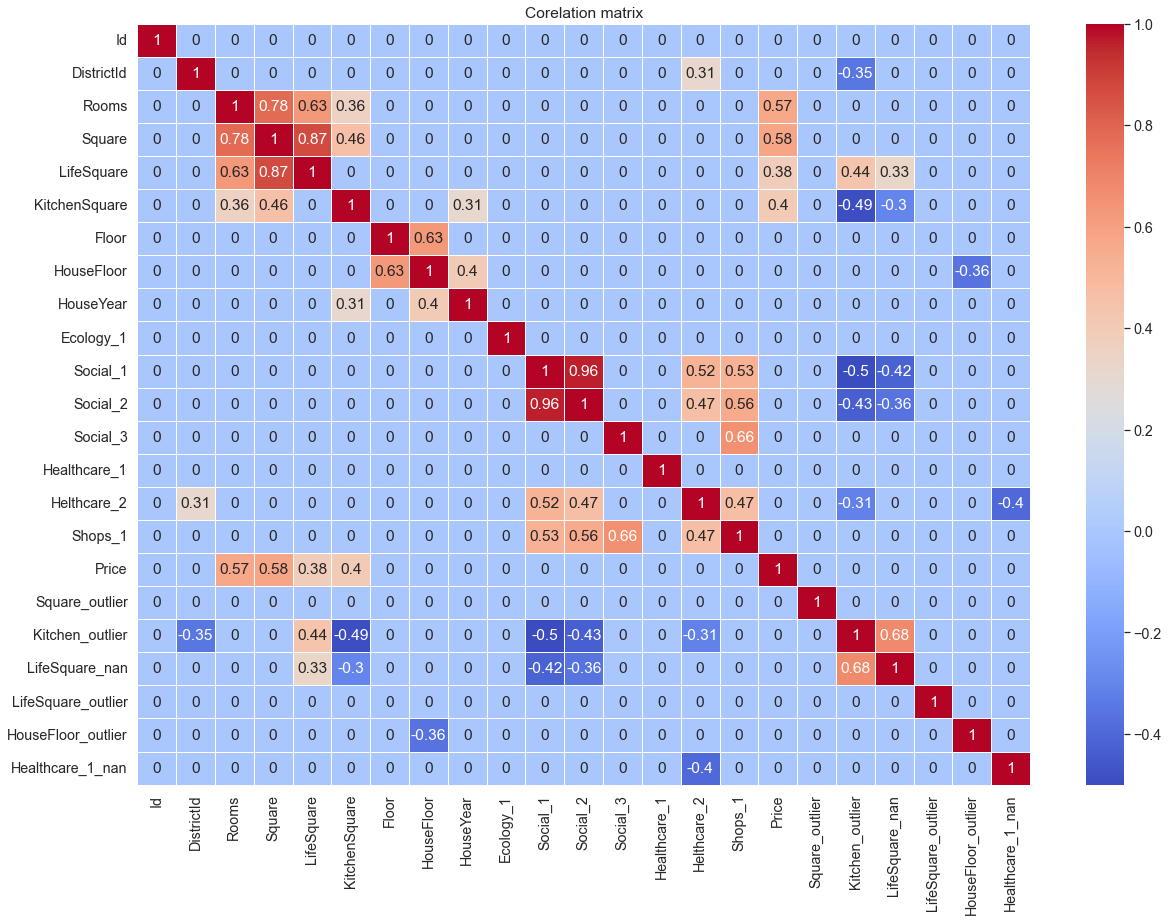

In [114]:
# Построим матрицу корреляций после обработки признаков
plt.figure(figsize=(20, 14))
sns.set(font_scale=1.3)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Corelation matrix')
plt.show()

### class DataPreprocessing

In [166]:
# Снова подгрузим данные
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'
PREPARED_DATASET_PATH = './data/train_prepared'

In [167]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [168]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [169]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [170]:
train_df['Id'] = train_df['Id'].astype(str)
train_df.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [171]:
# Оптимизируем данные в датасете (уменьшение объёма памяти)
def reduce_mem_usage(df):
    """
    Функция переберает все столбцы в датафрейме и
    измяняет тип данных
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Используемая память для датафрейма состовляет {:.2f} MB'.format(start_mem))
    i = 0
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # для 
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Используемая память после оптимизации датафрейма состовляет {:.2f} MB'.format(end_mem))
    print('Датафрейм уменьшился на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [172]:
train_df = reduce_mem_usage(train_df)

Используемая память для датафрейма состовляет 1.53 MB
Используемая память после оптимизации датафрейма состовляет 0.82 MB
Датафрейм уменьшился на 46.6%


In [173]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        # min, max квантилей для Square
        self.square_min_quantile = None
        self.square_max_quantile = None
        # медианы
        self.medians = None
        # текущий год
        self.current_year = None
        # все Social_1 для, которых существует Healthcare_1(датасет)
        self.healthcare_df = None
        
        
    def fit(self, X):
        """Сохранение и расчет статистик"""
        # Расчет квантилей min, max для Square
        self.square_min_quantile = np.quantile(X['Square'], q =0.012)
        self.square_max_quantile = np.quantile(X['Square'], q=0.998)
        self.medians = X.median()
        self.current_year = datetime.now().year
        # Сгруппируем все Social_1 для, которых существует Healthcare_1
        healthcare_df = X[['Social_1', 'Healthcare_1', 'Id']].\
                 groupby(by=['Social_1', 'Healthcare_1'], as_index=False).\
                 agg({'Id': 'count'})
        self.healthcare_df = healthcare_df[['Social_1', 'Healthcare_1']]
    
    
    def transform(self, X):
        """Обработка выбросов и пропусков"""
        
        # --Rooms--
        # Выберем квартиры, которые больше 5 комнат и площадь которых < 85 м2
        rooms_outlier_1 = X.loc[(X['Rooms'].between(5, 19)) & (X['Square'] < 85), ['Rooms', 'Square']]
        # Обработаем выбросы функцией rooms_square
        rooms_outlier_1 = self.rooms_square(rooms_outlier_1)
        # Изменим количество комнат в DataFraim
        X.loc[(X['Rooms'].between(5, 19)) & (X['Square'] < 85), 'Rooms'] = rooms_outlier_1['Rooms']
        # Так же обработаем 0 комнат
        rooms_outlier_2 = X.loc[X['Rooms'] == 0, ['Rooms', 'Square']]
        # Обработаем выбросы функцией rooms_square
        rooms_outlier_2 = self.rooms_square(rooms_outlier_2)
        # Изменим количество комнат
        X.loc[X['Rooms'] == 0, ['Rooms', 'Square']] = rooms_outlier_2[['Rooms', 'Square']]
    
        
        # --Square--
        # Создадим бинарный признак для выбросов для признака Square
        X['Square_outlier'] = 0
        # Условие для квартир меньше 11 кв.м или квартир более 120 кв.м
        condition_sq = (X['Square'] < 11) | (X['Square'] > 185)
        # Заполним 1, только те строки в которых есть выбросы
        X.loc[condition_sq, 'Square_outlier'] = 1
        # Заполним значение выбросов квантилями
        X.loc[X['Square'] < 11, 'Square'] = self.square_min_quantile
        X.loc[X['Square'] > 185, 'Square'] = self.square_max_quantile
        # Исправим выбросы площади, которые не соответствуют количеству комнат функцией rooms_square
        square_outlier = X.loc[X['Square_outlier'] == 1, ['Rooms', 'Square']]
        # Обработаем выбросы функцией rooms_square
        square_outlier = self.rooms_square(square_outlier)
        # Изменим количество комнат
        X.loc[X['Square_outlier'] == 1, ['Rooms', 'Square']] = square_outlier[['Rooms', 'Square']]
        
        
        # --KitchenSquare--
        # Создадим бинарный признак для выбросов для признака KitchenSquare
        X['Kitchen_outlier'] = 0
        # Заполним 1, только те строки в которых есть выбросы для KitchenSquare < 3
        X.loc[X['KitchenSquare'] < 3, 'Kitchen_outlier'] = 1
        # Исправим выбросы площади, которые не соответствуют функцией rooms_kitchen_square
        kitchen_outlier = X.loc[X['Kitchen_outlier'] == 1, ['Rooms', 'KitchenSquare']]
        # Обработаем выбросы функцией rooms_kitchen_square
        kitchen_outlier = self.rooms_kitchen_square(kitchen_outlier)
        # Заменим данные по площади кухни
        X.loc[X['Kitchen_outlier'] == 1, ['Rooms', 'KitchenSquare']] = kitchen_outlier[['Rooms', 'KitchenSquare']]
        # Заполним 1, только те строки в которых есть выбросы KitchenSquare > 33
        X.loc[X['KitchenSquare'] > 33, 'Kitchen_outlier'] = 1
        # Обработаем данные
        kitchen_outlier = X.loc[(X['Kitchen_outlier'] == 1) & (X['KitchenSquare'] > 33),\
                              ['Rooms', 'Square', 'KitchenSquare']]
        kitchen_outlier = self.rooms_kitchen_square(kitchen_outlier)
        # Заменим данные по площади кухни
        X.loc[(X['Kitchen_outlier'] == 1) & (X['KitchenSquare'] > 33), 'KitchenSquare']\
              = kitchen_outlier['KitchenSquare']
        
        
        # --Обработка пропусков--
        # --LifeSquare--
        # Создадим бинарный признак для пропусков для признака LifeSquare
        X['LifeSquare_nan'] = 0
        # Заполним 1, только те строки в которых есть пропуски
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        # Заполним пропуски (4 м2 на коридоры)
        condition = X['LifeSquare_nan'] == 1
        # Заполним пропуски LifeSquare (4 кв.м на коридоры)
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 4
        
        
        # --Обработка выбросов--
        # --Lifesquare--
        # Создадим бинарный признак для выбросов для признака Lifesquare
        X['LifeSquare_outlier'] = 0
        # Вариант, когда LifeSquare > Square
        # Заполним 1, только те строки в которых есть выбросы
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare_outlier'] = 1
        condition = X['LifeSquare_outlier'] == 1
        # Заполним выбросы LifeSquare (4 кв.м на коридоры)
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 4
        # Вариант, когда LifeSquare < KitchenSquare
        condition = X['LifeSquare'] < X['KitchenSquare']
        # Заполним 1, только те строки в которых есть выбросы
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 4
        
        
        # --Floor, HouseFloor--
        # Создадим бинарный признак для выбросов для признака HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['Floor'] > X['HouseFloor']) & (X['HouseFloor'] == 0), 'HouseFloor_outlier'] = 1
        # Заполним нулевую этажность мединой
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        floor_outlier = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outlier, 'Floor'] = X.loc[floor_outlier, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        
        # --HouseYear--
        X.loc[X['HouseYear'] > self.current_year, 'HouseYear'] = self.current_year
        
        
        # --Healthcare_1--
        # Создадим бинарный признак для пропусков для признака Healthcare_1
        X['Healthcare_1_nan'] = 0
        # Заполним 1, только те строки в которых есть пропуски
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        # Создадим список
        healthcare_1_to_list = self.healthcare_df['Healthcare_1'].to_list()
        # Создадим словарь со значениями Healthcare_1
        healthcare_values = pd.Series(healthcare_1_to_list, index=self.healthcare_df['Social_1']).to_dict()
        condition = X['Healthcare_1_nan'] == 1
        # Заполним пропуски значениями в словаре
        X.loc[condition, 'Healthcare_1'] = X.loc[condition, 'Social_1'].\
            apply(lambda x: healthcare_values.get(x, None))
        # --Если остались пропуски--
        # Создадим список всех уникальных значений Healthcare_1
        healthcare_random = X.loc[~X['Healthcare_1'].isna(), 'Healthcare_1'].unique().tolist()
        # Заполним пропуски значениями из списка healthcare_random
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'].\
            apply(lambda x: random.choice(healthcare_random))
        
        return X         
       
    
    # Функция для обработки выбросов rooms в зависимости от square
    def rooms_square(self, rooms_outlier):
        """Функция приведения rooms в зависимости от square"""
        for idx in rooms_outlier.index:
            square = rooms_outlier.loc[idx, 'Square']
            if  0 < square <= 45:
                rooms_outlier.loc[idx, 'Rooms'] = 1
                # Если площадь меньше 11 м2
                if square < 20:
                    rooms_outlier.loc[idx, 'Square'] = 15
            elif 45 < square <= 60:
                rooms_outlier.loc[idx, 'Rooms'] = 2
            elif 60 < square <= 80:
                rooms_outlier.loc[idx, 'Rooms'] = 3
            elif 80 < square <= 100:
                rooms_outlier.loc[idx, 'Rooms'] = 4
            elif 100 < square <= 140:
                rooms_outlier.loc[idx, 'Rooms'] = 5
            else:
                rooms_outlier.loc[idx, 'Rooms'] = 6
        
        return rooms_outlier
    
    
    # Напишем функцию для обработки выбросов KitchenSquare от Rooms
    def rooms_kitchen_square(self, kitchen_outlier):
        """Функция приведения KitchenSquare от Rooms"""
        for idx in kitchen_outlier.index:
            rooms = kitchen_outlier.loc[idx, 'Rooms']
            if rooms == 1:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 3
            elif rooms == 2:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 6
            elif rooms == 3:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 8
            elif rooms == 4:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 10
            elif rooms == 5:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 12
            else:
                kitchen_outlier.loc[idx, 'KitchenSquare'] = 25
        
        return kitchen_outlier

In [174]:
class FeatureGenerator():
    """Генерация новых признаков"""
    
    def __init__(self):
        
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    
    def fit(self, X, y=None):
        """Сохранение и расчет статистик"""
        
        X = X.copy()
        
        # Бинарные признаки
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Текущий год
        self.current_year = datetime.now().year
        
        
    def transform(self, X):
        """Обработка новых признаков"""
        
        # Бинарные признаки
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        
         # Создадим новый признак возраст дома
        X['House_age'] = self.current_year - X['HouseYear']
        
#         # Создадим новый признак категорию дома от возраста на основе House_age
#         X['house_cat_age'] = 0
#         # Заполним категориями
#         X.loc[X['House_age'] <= 5, 'house_cat_age'] = 1
#         X.loc[(X['House_age'] > 5) & (X['House_age'] <= 10), 'house_cat_age'] = 2
#         X.loc[(X['House_age'] > 10) & (X['House_age'] <= 25), 'house_cat_age'] = 3
#         X.loc[(X['House_age'] > 25) & (X['House_age'] <= 40), 'house_cat_age'] = 4
#         X.loc[(X['House_age'] > 40) & (X['House_age'] <= 65), 'house_cat_age'] = 5
#         X.loc[X['House_age'] > 65, 'house_cat_age'] = 6
        
         
        # Удалим год постройки
        X.drop(columns='HouseYear', inplace=True)
        
        return X

In [175]:
target_name = 'Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [176]:
# Разобъем данные на тренировочный и валидационный датафреймы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [177]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6700, 19), (3300, 19), (6700,), (3300,))

In [178]:
# Произведм обработку данных
prepocessor = DataPreprocessing()
prepocessor.fit(X_train)

X_train = prepocessor.transform(X_train)
X_valid = prepocessor.transform(X_valid)
test_df = prepocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [179]:
# Произведём генерацию новых признаков
feature_gen = FeatureGenerator()
feature_gen.fit(X_train, y_train)

X_train = feature_gen.transform(X_train)
X_valid = feature_gen.transform(X_valid)
test_df = feature_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [180]:
y_train.values

array([137057.73, 198393.45, 132782.67, ..., 196512.6 , 125817.71,
       248000.67], dtype=float32)

In [181]:
# Выберим признаки кроме Id и DistricId
X_train = X_train[list(X_train.columns[2:])]
X_valid = X_valid[list(X_valid.columns[2:])]
test_df = test_df[list(test_df.columns[2:])]

In [182]:
X_train.columns.shape, X_valid.columns.shape, test_df.columns.shape

((23,), (23,), (23,))

In [183]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan,House_age
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.00000
mean,1.893731,56.115635,39.292355,7.070149,7.409254,12.942389,0.119934,0.990746,0.971642,24.778209,5379.070000,7.888209,1402.398193,1.310597,4.217761,0.915672,0.002090,0.318060,0.211343,0.061642,0.027313,0.483284,37.17791
std,0.818174,18.752064,17.821131,2.703165,5.088203,6.324855,0.119617,0.095757,0.166006,17.629568,4033.819223,23.400692,1222.735718,1.492412,4.766738,0.277900,0.045667,0.465758,0.408292,0.240522,0.163007,0.499758,18.29840
min,1.000000,13.784864,2.784864,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,41.941182,26.219400,5.000000,3.000000,9.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.00000
50%,2.000000,52.621164,35.255007,7.000000,6.000000,13.000000,0.075779,1.000000,1.000000,25.000000,5285.000000,2.000000,1036.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.00000
75%,2.000000,65.765015,47.926352,9.000000,11.000000,17.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,2078.000000,2.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,48.00000
max,6.000000,183.382278,161.504227,32.000000,42.000000,99.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.00000


In [184]:
1sdf

SyntaxError: invalid syntax (3917365865.py, line 1)

In [185]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Square_outlier', 'Kitchen_outlier', 'LifeSquare_nan',
       'LifeSquare_outlier', 'HouseFloor_outlier', 'Healthcare_1_nan',
       'House_age'],
      dtype='object')

In [262]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 9239 to 5327
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               6700 non-null   float32
 1   Square              6700 non-null   float32
 2   LifeSquare          6700 non-null   float32
 3   KitchenSquare       6700 non-null   float32
 4   Floor               6700 non-null   int64  
 5   HouseFloor          6700 non-null   float32
 6   Ecology_1           6700 non-null   float32
 7   Ecology_2           6700 non-null   int64  
 8   Ecology_3           6700 non-null   int64  
 9   Social_1            6700 non-null   int8   
 10  Social_2            6700 non-null   int16  
 11  Social_3            6700 non-null   int16  
 12  Healthcare_1        6700 non-null   float32
 13  Helthcare_2         6700 non-null   int8   
 14  Shops_1             6700 non-null   int8   
 15  Shops_2             6700 non-null   int64  
 16  Squ

In [263]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'House_age']

In [456]:
X_train_f = X_train#[features]
X_valid_f = X_valid#[features]
test_df_f = test_df#[features]

### Построение модели

In [457]:
from sklearn.preprocessing import StandardScaler

In [458]:
scaler = StandardScaler()

In [459]:
X_train_f = pd.DataFrame(scaler.fit_transform(X_train_f), columns=X_train_f.columns)
X_valid_f = pd.DataFrame(scaler.transform(X_valid_f), columns=X_valid_f.columns)
test_df_f = pd.DataFrame(scaler.transform(test_df_f), columns=test_df_f.columns)

In [460]:
X_train_f.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan,House_age
count,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03,6.700000e+03
mean,6.071429e-17,-1.219257e-16,1.681905e-16,-1.673785e-16,1.095972e-16,-1.334753e-17,8.232221e-17,5.406538e-17,3.263973e-16,7.035831e-17,1.207326e-16,-3.480963e-16,-5.153423e-18,-1.736381e-16,-1.696156e-16,6.031079e-16,-2.100289e-16,9.435239e-17,-2.049439e-16,-1.168700e-15,1.513085e-15,-1.904612e-16,2.386814e-16
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-1.092434e+00,-2.257563e+00,-2.048701e+00,-1.505798e+00,-1.259724e+00,-1.888322e+00,-1.002709e+00,-1.034720e+01,-5.853474e+00,-1.405596e+00,-1.291942e+00,-3.371181e-01,-1.122484e+00,-8.782390e-01,-8.848978e-01,-3.295210e+00,-4.575945e-02,-6.829378e-01,-5.176667e-01,-2.563028e-01,-1.675721e-01,-9.671078e-01,-2.031909e+00
25%,-1.092434e+00,-7.559449e-01,-7.336170e-01,-7.658754e-01,-8.666287e-01,-6.233675e-01,-8.551692e-01,9.664452e-02,1.708387e-01,-1.065234e+00,-9.458418e-01,-3.371181e-01,-7.053549e-01,-8.782390e-01,-6.750951e-01,3.034708e-01,-4.575945e-02,-6.829378e-01,-5.176667e-01,-2.563028e-01,-1.675721e-01,-9.671078e-01,-8.841821e-01
50%,1.298953e-01,-1.863656e-01,-2.265628e-01,-2.595252e-02,-2.769856e-01,9.109558e-03,-3.691533e-01,9.664452e-02,1.708387e-01,1.258157e-02,-2.332207e-02,-2.516442e-01,-2.996768e-01,-2.081330e-01,-2.554896e-01,3.034708e-01,-4.575945e-02,-6.829378e-01,-5.176667e-01,-2.563028e-01,-1.675721e-01,-9.671078e-01,4.275059e-01
75%,1.298953e-01,5.146155e-01,4.845195e-01,7.139704e-01,7.057530e-01,6.415866e-01,6.341381e-01,9.664452e-02,1.708387e-01,6.365799e-01,4.730188e-01,-1.234333e-01,5.525742e-01,4.619731e-01,3.739186e-01,3.034708e-01,-4.575945e-02,1.464262e+00,-5.176667e-01,-2.563028e-01,-1.675721e-01,1.034011e+00,5.914669e-01
max,5.019213e+00,6.787319e+00,6.858208e+00,9.223084e+00,6.798732e+00,1.360737e+01,3.360413e+00,9.664452e-02,1.708387e-01,2.792210e+00,3.397513e+00,5.688795e+00,2.818973e+00,3.142397e+00,3.940565e+00,3.034708e-01,2.185341e+01,1.464262e+00,1.931745e+00,3.901636e+00,5.967581e+00,1.034011e+00,3.979994e+00


In [461]:
X_valid_f.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan,House_age
count,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000
mean,-0.012710,0.013500,0.009671,0.011492,-0.002712,0.008008,-0.027239,-0.014124,0.015667,-0.015679,-0.020219,0.019554,-0.026628,0.018079,0.008608,0.019938,0.000693,0.008721,-0.000321,0.024673,-0.007686,-0.021124,-0.008399
std,1.005431,1.032235,1.005625,1.041286,0.970122,1.056034,0.984891,1.070010,0.954464,0.983381,0.979645,1.054959,0.990228,1.002528,1.025174,0.969658,1.007684,1.003515,0.999924,1.043869,0.977574,0.999221,1.019741
min,-1.092434,-2.192758,-2.020423,-1.505798,-1.259724,-1.888322,-1.002709,-10.347198,-5.853474,-1.405596,-1.291942,-0.337118,-1.147021,-0.878239,-0.884898,-3.295210,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,-2.031909
25%,-1.092434,-0.781281,-0.752326,-0.765875,-0.670081,-0.623367,-0.855169,0.096645,0.170839,-1.065234,-0.945842,-0.337118,-0.705355,-0.878239,-0.675095,0.303471,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,-0.938836
50%,0.129895,-0.205833,-0.248842,-0.025953,-0.276986,0.009110,-0.399428,0.096645,0.170839,0.012582,-0.023322,-0.251644,-0.306220,-0.208133,-0.255490,0.303471,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,0.427506
75%,0.129895,0.553337,0.514511,0.713970,0.509205,0.641587,0.623338,0.096645,0.170839,0.636580,0.420955,-0.123433,0.483871,0.461973,0.216567,0.303471,-0.045759,1.464262,-0.517667,-0.256303,-0.167572,1.034011,0.591467
max,5.019213,6.321588,6.634059,8.483161,3.653969,16.453513,3.360413,0.096645,0.170839,2.792210,3.397513,5.688795,2.818973,3.142397,3.940565,0.303471,21.853408,1.464262,1.931745,3.901636,5.967581,1.034011,4.089301


In [462]:
test_df_f.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan,House_age
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.018419,0.018586,0.011103,-0.005679,0.022042,-0.000125,-0.000491,-0.003616,-0.008686,0.008826,0.006900,0.016000,-0.010393,0.005899,0.005253,0.006940,0.002419,-0.019453,-0.007699,0.011468,-0.006831,-0.015776,0.023473
std,0.994690,1.002587,0.983908,0.977734,1.009177,1.022539,1.003856,1.018462,1.024448,0.994551,0.998288,1.019865,1.023714,0.991717,1.002304,0.989640,1.026134,0.992280,0.994611,1.020727,0.980064,0.999448,1.015091
min,-1.092434,-2.283127,-2.824694,-1.505798,-1.259724,-1.888322,-1.002709,-10.347198,-5.853474,-1.405596,-1.291942,-0.337118,-1.147021,-0.878239,-0.884898,-3.295210,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,-1.922602
25%,-1.092434,-0.757809,-0.714323,-0.765875,-0.670081,-0.623367,-0.839604,0.096645,0.170839,-1.065234,-0.945842,-0.337118,-0.844398,-0.878239,-0.675095,0.303471,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,-0.829528
50%,0.129895,-0.170357,-0.222266,-0.025953,-0.276986,0.009110,-0.399428,0.096645,0.170839,0.012582,-0.023322,-0.251644,-0.316853,-0.208133,-0.255490,0.303471,-0.045759,-0.682938,-0.517667,-0.256303,-0.167572,-0.967108,0.427506
75%,0.129895,0.542354,0.514097,0.713970,0.705753,0.641587,0.634138,0.096645,0.170839,0.636580,0.473019,-0.123433,0.483871,0.461973,0.373919,0.303471,-0.045759,1.464262,-0.517667,-0.256303,-0.167572,1.034011,0.646121
max,5.019213,6.285587,6.567614,9.593045,7.584923,13.607366,3.360413,0.096645,0.170839,2.792210,3.397513,5.688795,2.818973,3.142397,3.940565,0.303471,21.853408,1.464262,1.931745,3.901636,5.967581,1.034011,4.198609


#### Обучение

In [463]:
from sklearn.svm import SVR

In [486]:
np.logspace(5.72, 5.77, 8)

array([524807.46024977, 533510.3599133 , 542357.58005298, 551351.5139401 ,
       560494.59453363, 569789.29513841, 579238.13007414, 588843.65535559])

In [487]:
c_values = np.logspace(5.72, 5.77, 8)

r2_on_train = []
r2_on_valid = []

for value in c_values:
    svr = SVR(C=value, kernel='rbf', gamma='auto')
    svr.fit(X_train_f, y_train)
    
    y_train_preds = svr.predict(X_train_f)
    y_valid_preds = svr.predict(X_valid_f)
    
    train_r2 = round(r2_score(y_train, y_train_preds), 3)
    valid_r2 = round(r2_score(y_valid, y_valid_preds), 3)
    
    print(f'C = {value}')
    print(f'train_r2 = {train_r2}')
    print(f'valid_r2 = {valid_r2}')
        
    r2_on_train.append(train_r2)
    r2_on_valid.append(valid_r2)
    

C = 524807.4602497723
train_r2 = 0.812
valid_r2 = 0.719
C = 533510.3599132969
train_r2 = 0.813
valid_r2 = 0.72
C = 542357.5800529773
train_r2 = 0.813
valid_r2 = 0.719


KeyboardInterrupt: 

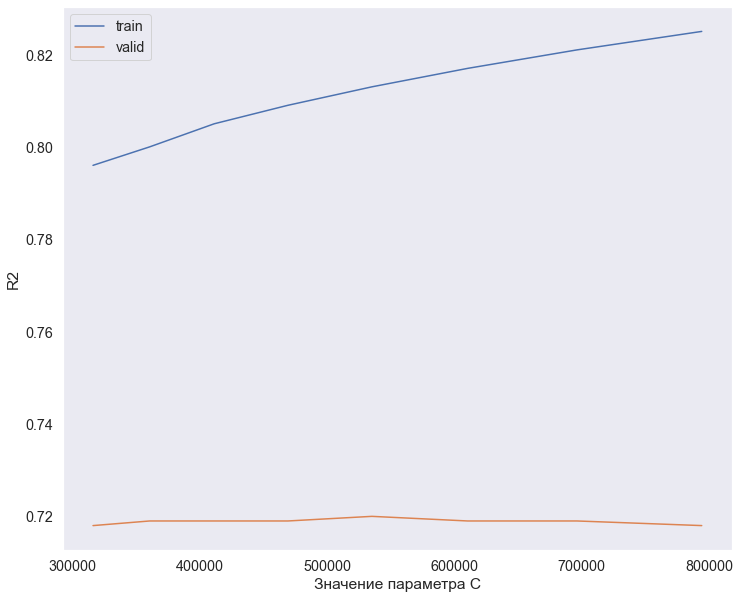

In [478]:
plt.plot(c_values, r2_on_train, label='train')
plt.plot(c_values, r2_on_valid, label='valid')

plt.xlabel('Значение параметра С')
plt.ylabel('R2')

plt.legend()
plt.grid()

plt.show()

In [498]:
svr = SVR(C=535268, kernel='rbf', gamma='auto')
svr.fit(X_train_f, y_train)

SVR(C=535268, gamma='auto')

#### Оценка качества модели

In [499]:
# Сделаем предсказания
y_train_preds = svr.predict(X_train_f)
y_valid_preds = svr.predict(X_valid_f)

In [500]:
def evaluate_preds(train_true_values, train_pred_values, valid_true_values, valid_pred_values):
    train_r2 = round(r2_score(train_true_values, train_pred_values), 3)
    valid_r2 = round(r2_score(valid_true_values, valid_pred_values), 3)
    print(f'Train_R2 = {train_r2}\nValid_R2 = {valid_r2}')
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=valid_pred_values, y=valid_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Valid sample prediction')

    plt.show()

Train_R2 = 0.813
Valid_R2 = 0.72


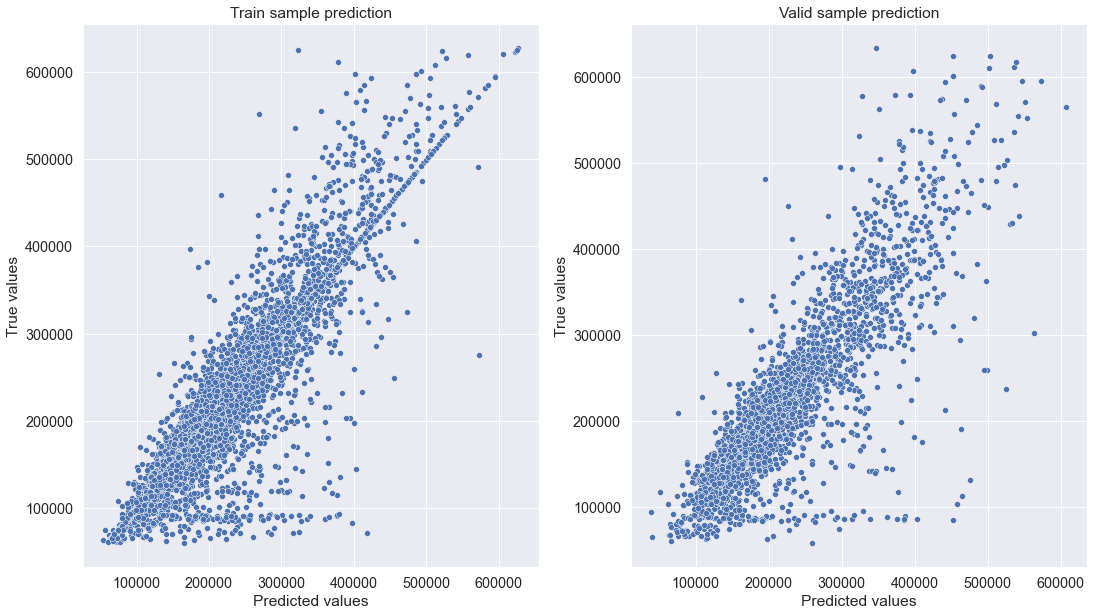

In [501]:
# Построим графики переобучение и предсказания модели
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Вывод:

In [502]:
### Прогнозирование на тестовом датасете

In [503]:
test_df.shape

(5000, 23)

In [504]:
test_df.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Square_outlier,Kitchen_outlier,LifeSquare_nan,LifeSquare_outlier,HouseFloor_outlier,Healthcare_1_nan,House_age
0,1.0,36.847630,19.094182,5.0,5,9.0,0.036122,1,1,24,4378,0,1036.0,1,1,1,0,0,0,0,0,0,52
1,1.0,42.493907,28.493907,10.0,7,17.0,0.072158,1,1,2,629,1,2672.0,0,0,0,0,0,0,1,0,1,5
2,2.0,59.463678,46.463678,9.0,19,19.0,0.211401,1,1,9,1892,0,1430.0,0,1,1,0,0,1,0,0,1,45
3,3.0,49.646030,33.893825,6.0,2,2.0,0.014073,1,1,2,475,0,75.0,0,0,1,0,0,0,0,0,1,57
4,1.0,53.837056,46.837056,3.0,8,17.0,0.309479,1,1,35,7715,4,990.0,0,6,1,0,1,1,0,0,0,45


In [505]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [506]:
# Сделаем предсказание на тестовых данных
prediction = svr.predict(test_df_f)
prediction

array([166674.20474938, 106488.78495179, 141830.64906104, ...,
       146223.47446786, 195518.23861738, 287684.56385437])

In [507]:
# Запишем их
submit['Price'] = prediction
submit.head(10)

,Id,Price
0,4567,166674.204749
1,5925,106488.784952
2,960,141830.649061
3,3848,130935.183423
4,746,181038.791034
5,868,384727.854538
6,672,113662.134566
7,2471,225502.401964
8,4510,114530.536354
9,8354,266113.731199


In [508]:
submit.to_csv('ArtemKomarnitsky_predictions_SVR.csv', index=False)